순환 신경망 모델에서 주로 사용하는 LSTM 레이어에 대해서 알아보겠습니다. 시퀀스 데이터를 다루는 레이어라 설정 파라미터에 따라 다양하게 모델을 구성할 수 있습니다. 그만큼 헷갈리는 부분도 있지만 쉬운 예제부터 차근히 살펴보겠습니다.

---

### 긴 시퀀스를 기억할 수 있는 LSTM (Long Short-Term Memory units)  레이어

케라스에서 제공하는 순환 신경망 레이어는 SimpleRNN, GRU, LSTM이 있으나 주로 사용하는 LSTM에 대해서 알아보겠습니다. 이 LSTM은 아래와 같이 간단히 사용할 수 있습니다.

    LSTM(3, input_dim=1)

주요 인자는 다음과 같습니다.
* 첫번째 인자 : 출력 뉴런의 수 입니다.
* input_dim : 입력 뉴런의 수 입니다.

이는 앞서 살펴본 Dense 레이어 형태와 비슷합니다.

    Dense(3, input_dim=1)
    
Dense와 LSTM을 레고 블록으로 도식화 하면 다음과 같습니다. 왼쪽이 Dense이고, 오른쪽이 LSTM 입니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-4-9-RNN_Layer_Talk_1.png)
    
사실 LSTM의 내부구조는 복잡하지만 간소화하여 외형만 표시한 것입니다. Dense 레이어와 비교한다면 히든 뉴런들이 밖으로 도출되어 있음을 보실 수 있습니다. 이러한 히든 뉴런이 재귀적으로 다시 입력으로 들어가게 되어 순환 신경망이 되는 것입니다. 간단한 예제로 하나 하나 살펴보겠습니다. 

#### 시퀀스 데이터 준비

순환 신경망은 주로 자연어 처리에 많이 쓰이기 때문에 문장 학습 예제가 일반적이지만 본 강좌에서는 악보 학습을 해보겠습니다. 그 이유는 
- 음계가 문장보다 더 코드화 하기 쉽고, 
- 시계열 자료이며, 
- 나온 결과를 악보로 볼 수 있으며,
- 무엇보다 우리가 학습한 모델이 연주하는 곡을 들어볼 수 있기 때문입니다. 
일단 쉬운 악보인 '나비야'를 준비했습니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-4-9-RNN_Layer_Talk_2.png)

음표 밑에 간단한 음표코드를 표시하였습니다. 알파벳은 음계를 나타내며, 숫자는 음의 길이를 나타냅니다.
- c(도), d(레), e(미), f(파), g(솔), a(라), b(시)
- 4(4분음표), 8(8분음표)

#### 문제 정의

"나비야"노래는 우리에게 너무나 익숙한 노래입니다. 만약 옆사람이 "나비야~ 나"까지만 불러도 나머지를 이어서 다 부를 수 있을 정도로 말이죠. 이렇게 첫 4개 음표를 입력하면 나머지를 연주할 수 있는 모델을 만드는 것이 목표입니다. 이를 위해서 다음과 같이 학습을 시켜보겠습니다. 

- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다. 
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-4-9-RNN_Layer_Talk_3.png)

총 음계가 7개이고 음길이가 2개이기 때문에 구성할 수 있는 음표는 총 14개입니다. 따라서 다중 클래스 분류 문제로 풀어보도록 하겠습니다. 첫 줄 코드는 다음과 같습니다. 

* g8 e8 e4 | f8 d8 d4 | c8 d8 e8 f8 | g8 g8 g4

첫 줄에 대해 음표 4개 입력과 1개 출력을 구성하는 데이터셋은 다음과 같습니다. 1~4번째 열은 속성(feature)이고, 5번째 열은 클래스(class)를 나타냅니다.

* g8, e8, e4, f8, d8
* e8, e4, f8, d8, d4
* e4, f8, d8, d4, c8
* f8, d8, d4, c8, d8
* d8, d4, c8, d8, e8
* d4, c8, d8, e8, f8
* c8, d8, e8, f8, g8
* d8, e8, f8, g8, g8
* e8, f8, g8, g8, g4
* ...

이렇게 4개씩 구간을 보는 것을 윈도우 사이즈가 4라고 합니다. 시퀀스 데이터를 윈도우 사이즈만큼 잘라서 데이터셋을 구성하는 코드는 다음과 같습니다.

In [16]:
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        dataset.append(seq[i:(i+window_size+1)])
    return np.array(dataset)

그럼 seq2dataset 함수를 이용해서 윈도우 사이즈 만큼 잘라서 데이터셋을 만들어보도록 하겠습니다.

In [17]:
import numpy as np

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, 4)

print(dataset.shape)
print(dataset)

(50, 5)
[['g8' 'e8' 'e4' 'f8' 'd8']
 ['e8' 'e4' 'f8' 'd8' 'd4']
 ['e4' 'f8' 'd8' 'd4' 'c8']
 ['f8' 'd8' 'd4' 'c8' 'd8']
 ['d8' 'd4' 'c8' 'd8' 'e8']
 ['d4' 'c8' 'd8' 'e8' 'f8']
 ['c8' 'd8' 'e8' 'f8' 'g8']
 ['d8' 'e8' 'f8' 'g8' 'g8']
 ['e8' 'f8' 'g8' 'g8' 'g4']
 ['f8' 'g8' 'g8' 'g4' 'g8']
 ['g8' 'g8' 'g4' 'g8' 'e8']
 ['g8' 'g4' 'g8' 'e8' 'e8']
 ['g4' 'g8' 'e8' 'e8' 'e8']
 ['g8' 'e8' 'e8' 'e8' 'f8']
 ['e8' 'e8' 'e8' 'f8' 'd8']
 ['e8' 'e8' 'f8' 'd8' 'd4']
 ['e8' 'f8' 'd8' 'd4' 'c8']
 ['f8' 'd8' 'd4' 'c8' 'e8']
 ['d8' 'd4' 'c8' 'e8' 'g8']
 ['d4' 'c8' 'e8' 'g8' 'g8']
 ['c8' 'e8' 'g8' 'g8' 'e8']
 ['e8' 'g8' 'g8' 'e8' 'e8']
 ['g8' 'g8' 'e8' 'e8' 'e4']
 ['g8' 'e8' 'e8' 'e4' 'd8']
 ['e8' 'e8' 'e4' 'd8' 'd8']
 ['e8' 'e4' 'd8' 'd8' 'd8']
 ['e4' 'd8' 'd8' 'd8' 'd8']
 ['d8' 'd8' 'd8' 'd8' 'd8']
 ['d8' 'd8' 'd8' 'd8' 'e8']
 ['d8' 'd8' 'd8' 'e8' 'f4']
 ['d8' 'd8' 'e8' 'f4' 'e8']
 ['d8' 'e8' 'f4' 'e8' 'e8']
 ['e8' 'f4' 'e8' 'e8' 'e8']
 ['f4' 'e8' 'e8' 'e8' 'e8']
 ['e8' 'e8' 'e8' 'e8' 'e8']
 ['e8' 'e8' 

4개의 속성과 1개의 클래스 값으로 구성된 샘플이 총 50개가 생성되었습니다. 모델에 데이터를 입력하기 위해서는 문자가 아닌 정수나 실수 등으로 수치를 입력해야 합니다. 각 음표에 대해서 임의의 정수를 부여하고, 이를 변환하는 자료형을 만들어보겠습니다. 추가로 seq2dataset() 함수를 수정해서, 음표 집합을 입력하면 정수 데이터셋을 반환하도록 수정하겠습니다.

In [24]:
code2int = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

int2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2int[item] for item in subset])
    return np.array(dataset)

dataset = seq2dataset(seq, 4)

print(dataset.shape)
print(dataset)

7
(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 입력(X)과 출력(Y) 변수로 분리하기
X = dataset[:,0:4]
Y = dataset[:,4]

# normalize
X = X / float(14)
# one hot encode the output variable
Y = np_utils.to_categorical(Y)

# 모델 구성하기
model = Sequential()
model.add(Dense(12, input_dim=4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(Y.shape[1], activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
model.fit(X, Y, epochs=100, batch_size=10, verbose=2)

# 모델 평가하기
scores = model.evaluate(X, Y)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

Epoch 1/100
0s - loss: 2.4838 - acc: 0.1400
Epoch 2/100
0s - loss: 2.4788 - acc: 0.3400
Epoch 3/100
0s - loss: 2.4740 - acc: 0.3400
Epoch 4/100
0s - loss: 2.4691 - acc: 0.3400
Epoch 5/100
0s - loss: 2.4639 - acc: 0.3400
Epoch 6/100
0s - loss: 2.4589 - acc: 0.3400
Epoch 7/100
0s - loss: 2.4527 - acc: 0.3400
Epoch 8/100
0s - loss: 2.4464 - acc: 0.3400
Epoch 9/100
0s - loss: 2.4394 - acc: 0.3400
Epoch 10/100
0s - loss: 2.4317 - acc: 0.3400
Epoch 11/100
0s - loss: 2.4236 - acc: 0.3400
Epoch 12/100
0s - loss: 2.4138 - acc: 0.3400
Epoch 13/100
0s - loss: 2.4055 - acc: 0.3400
Epoch 14/100
0s - loss: 2.3931 - acc: 0.3400
Epoch 15/100
0s - loss: 2.3812 - acc: 0.3400
Epoch 16/100
0s - loss: 2.3678 - acc: 0.3400
Epoch 17/100
0s - loss: 2.3534 - acc: 0.3400
Epoch 18/100
0s - loss: 2.3378 - acc: 0.3400
Epoch 19/100
0s - loss: 2.3227 - acc: 0.3400
Epoch 20/100
0s - loss: 2.3073 - acc: 0.3400
Epoch 21/100
0s - loss: 2.2882 - acc: 0.3400
Epoch 22/100
0s - loss: 2.2707 - acc: 0.3400
Epoch 23/100
0s - l

In [53]:
test_X = ['g8', 'e8', 'e4', 'f8']
test_X = np.array([[code2int[item] for item in test_X]])
prediction = model.predict(test_X)
prediction_idx = np.argmax(prediction)
result = int2code[prediction_idx]
print(result)

e8


In [ ]:
Abstract base class for recurrent layers.

Do not use in a model -- it's not a valid layer! Use its children classes LSTM, GRU and SimpleRNN instead.

All recurrent layers (LSTM, GRU, SimpleRNN) also follow the specifications of this class and accept the keyword arguments listed below.

Example

# as the first layer in a Sequential model
model = Sequential()
model.add(LSTM(32, input_shape=(10, 64)))
# now model.output_shape == (None, 32)
# note: `None` is the batch dimension.

# for subsequent layers, no need to specify the input size:
model.add(LSTM(16))

# to stack recurrent layers, you must use return_sequences=True
# on any recurrent layer that feeds into another recurrent layer.
# note that you only need to specify the input size on the first layer.
model = Sequential()
model.add(LSTM(64, input_dim=64, input_length=10, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(10))

---

### 사소한 변화를 무시해주는 맥스풀링(Max Pooling) 레이어

컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듭니다. 이것은 지역적인 사소한 변화가 영향을 미치지 않도록 합니다. 

    MaxPooling2D(pool_size=(2, 2))

주요 인자는 다음과 같습니다.
* pool_size : 수직, 수평 축소 비율을 지정합니다. (2, 2)이면 출력 영상 크기는 입력 영상 크기의 반으로 줄어듭니다.

예를 들어, 입력 영상 크기가 4 x 4이고, 풀 크기를 (2, 2)로 했을 때를 도식화하면 다음과 같습니다. 녹색 블럭은 입력 영상을 나타내고, 노란색 블럭은 풀 크기에 따라 나눈 경계를 표시합니다. 해당 풀에서 가장 큰 값을 선택하여 파란 블럭으로 만들면, 그것이 출력 영상이 됩니다. 가장 오른쪽은 맥스풀링 레이어를 약식으로 표시한 것입니다.

![lego_12](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_12.png)

이 레이어는 영상의 작은 변화라던지 사소한 움직임이 특징을 추출할 때 크게 영향을 미치지 않도록 합니다. 영상 내에 특징이 세 개가 있다고 가정했을 때, 아래 그림에서 첫 번째 영상을 기준으로 두 번째 영상은 오른쪽으로 이동하였고, 세 번째 영상은 약간 비틀어 졌고, 네 번째 영상은 조금 확대되었지만, 맥스풀링한 결과는 모두 동일합니다. 얼굴 인식 문제를 예를 들면, 맥스풀링의 역할은 사람마다 눈, 코, 입 위치가 조금씩 다른데 이러한 차이가 사람이라고 인식하는 데 있어서는 큰 영향을 미치지 않게 합니다.

![lego_13](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_13.png)

---

### 영상을 일차원으로 바꿔주는 플래튼(Flatten) 레이어

CNN에서 컨볼루션 레이어나 맥스풀링 레이어를 반복적으로 거치면 주요 특징만 추출되고, 추출된 주요 특징은 전결합층에 전달되어 학습됩니다. 컨볼루션 레이어나 맥스풀링 레이어는 주로 2차원 자료를 다루지만 전결합층에 전달하기 위해선 1차원 자료로 바꿔줘야 합니다. 이 때 사용되는 것이 플래튼 레이어입니다. 사용 예시는 다음과 같습니다.

    Flatten()
    
이전 레이어의 출력 정보를 이용하여 입력 정보를 자동으로 설정되며, 출력 형태는 입력 형태에 따라 자동으로 계산되기 때문에 별도로 사용자가 파라미터를 지정해주지 않아도 됩니다. 크기가 3 x 3인 영상을 1차원으로 변경했을 때는 도식화하면 다음과 같습니다.

![lego_14](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_14.png)

---

### 한 번 쌓아보기

지금까지 알아본 레이어를 이용해서 간단한 컨볼루션 신경망 모델을 만들어보겠습니다. 먼저 간단한 문제를 정의해봅시다. 손으로 삼각형, 사각형, 원을 손으로 그린 이미지가 있고 이미지 크기가 8 x 8이라고 가정해봅니다. 삼각형, 사각형, 원을 구분하는 3개의 클래스를 분류하는 문제이기 때문에 출력 벡터는 3개여야 합니다. 필요하다고 생각하는 레이어를 구성해봤습니다.

![lego_22](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_22.png)

* 컨볼루션 레이어 : 입력 이미지 크기 8 x 8, 입력 이미지 채널 1개, 필터 크기 3 x 3, 필터 수 2개, 경계 타입 'same', 활성화 함수 'relu'

![lego_15](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_15.png)

* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_16](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_16.png)

* 컨볼루션 레이어 : 입력 이미지 크기 4 x 4, 입력 이미지 채널 2개, 필터 크기 2 x 2, 필터 수 3개, 경계 타입 'same', 활성화 함수 'relu'

![lego_17](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_17.png)

* 맥스풀링 레이어 : 풀 크기 2 x 2

![lego_18](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_18.png)

* 플래튼 레이어

![lego_19](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_19.png)

* 댄스 레이어 : 입력 뉴런 수 12개, 출력 뉴런 수 8개, 활성화 함수 'relu'

![lego_20](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_20.png)

* 댄스 레이어 : 입력 뉴런 수 8개, 출력 뉴런 수 3개, 활성화 함수 'softmax'

![lego_21](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_21.png)

모든 레이어 블럭이 준비되었으니 이를 조합해 봅니다. 입출력 크기만 맞으면 레고 끼우듯이 합치면 됩니다. 참고로 케라스 코드에서는 가장 첫번째 레이어를 제외하고는 입력 형태를 자동으로 계산하므로 이 부분은 신경쓰지 않아도 됩니다. 레이어를 조립하니 간단한 컨볼루션 모델이 생성되었습니다. 이 모델에 이미지를 입력하면, 삼각형, 사각형, 원을 나타내는 벡터가 출력됩니다.

![lego_23](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_lego_23.png)

그럼 케라스 코드로 어떻게 구현하는 지 알아봅니다. 먼저 필요한 패키지를 추가하는 과정입니다. 케라스의 레이어는 'keras.layers'에 정의되어 있으며, 여기서 필요한 레이어를 추가합니다. 

In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

import numpy

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

Using Theano backend.


Sequential 모델을 하나 생성한 뒤 위에서 정의한 레이어를 차례차레 추가하면 컨볼루션 모델이 생성됩니다.

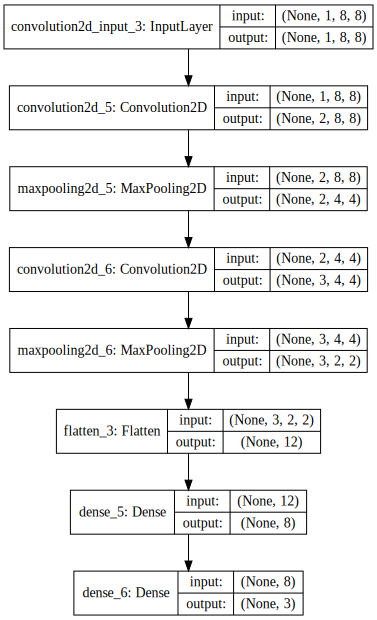

In [4]:
model = Sequential()

model.add(Convolution2D(2, 3, 3, border_mode='same', input_shape=(1, 8, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(3, 2, 2, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![model](http://tykimos.github.com/Keras/warehouse/2017-1-27_CNN_Layer_Talk_model.png)

---

### 결론

본 강좌를 통해 컨볼루션 모델에서 사용되는 주요 레이어에 대해서 알아보았고, 레이어를 조합하여 컨볼루션 모델을 만들어봤습니다. 다음 강좌에서는 이 모델을 이용하여 실제로 데이터셋을 학습시킨 후 분류가 제대로 되는 지 알아보겠습니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [딥러닝 이야기/다층 퍼셉트론 모델 만들어보기](https://tykimos.github.io/Keras/2017/02/04/MLP_Getting_Started/)
* 다음 : [딥러닝 이야기/컨볼루션 신경망 모델 만들어보기](https://tykimos.github.io/Keras/2017/03/08/CNN_Getting_Started/)

In [ ]:
\paper { 
  indent = 0\mm
}

\header{
  title = "나 비 야"
}

melody = \relative c'' {
\clef treble
\key c \major
\autoBeamOff
\time 2/4
g8 e8 e4 
f8 d8 d4 
c8 d8 e8 f8 
g8 g8 g4
\break
g8 e8 e8 e8 
f8 d8 d4
c8 e8 g8 g8 
e8 e8 e4
\break
d8 d8 d8 d8 
d8 e8 f4 
e8 e8 e8 e8 
e8 f8 g4
\break
g8 e8 e4 
f8 d8 d4 
c8 e8 g8 g8 
e8 e8 e4
}

\addlyrics {
#"g8" #"e8" #"e4"
#"f8" #"d8" #"d4"
#"c8" #"d8" #"e8" #"f8"
#"g8" #"g8" #"g4"
#"g8" #"e8" #"e8" #"e8" 
#"f8" #"d8" #"d4"
#"c8" #"e8" #"g8" #"g8"
#"e8" #"e8" #"e4"
#"d8" #"d8" #"d8" #"d8"
#"d8" #"e8" #"f4"
#"e8" #"e8" #"e8" #"e8"
#"e8" #"f8" #"g4"
#"g8" #"e8" #"e4" 
#"f8" #"d8" #"d4" 
#"c8" #"e8" #"g8" #"g8"
#"e8" #"e8" #"e4"
}

\score {
  \new Staff \melody
  \layout { }
  \midi { }
}

\version "2.18.2"  % necessary for upgrading to future LilyPond versions.
